<a href="https://colab.research.google.com/github/Bo-kyoung/practices/blob/main/VGG16_CIFAR10_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torchvision import models
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
  print("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
from torchvision import models
from torchsummary import summary
from torch.utils.data import TensorDataset

cuda


In [2]:
learning_rate = 0.01
training_epochs = 74
batch_size = 256

In [3]:
CIFAR10_train = dsets.CIFAR10(root='data/',train = True, download=True, transform=transform)
CIFAR10_test = dsets.CIFAR10(root='data/', train=False, download = True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [4]:
length_train = len(CIFAR10_train)
train_set, valid_set = torch.utils.data.random_split(CIFAR10_train, [int(length_train *0.8) , int(length_train *0.2)])


In [5]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True,drop_last = True)
test_loader = DataLoader(dataset = CIFAR10_test, batch_size = batch_size, shuffle = False,drop_last = True)
valid_loader = DataLoader(dataset = valid_set, batch_size = batch_size, shuffle = False,drop_last = True)

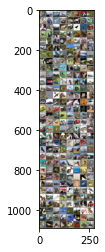

  cat   ship   ship  plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(test_loader)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('  '.join('%5s' % classes[labels[j]] for j in range(4)))


In [7]:
class VGG16(nn.Module):
  def __init__(self, init_weights = True):
    super(VGG16, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =128,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =256,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        )
    if init_weights: 
      self._initialize_weights()
    
    self.classfier = nn.Sequential(
    nn.Linear(4*4*512,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,10)
    )
  
  


  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0),-1)
    out = self.classfier(out)
    return out
#https://blog.naver.com/PostView.naver?blogId=mmmy2513&logNo=222300615187
#https://blogofth-lee.tistory.com/265?category=872318
  def _initialize_weights(self): 
    for m in self.modules(): 
      if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
        if m.bias is not None: 
          nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.BatchNorm2d): 
        nn.init.constant_(m.weight, 1) 
        nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.Linear): 
        nn.init.normal_(m.weight,0,0.01) 
        nn.init.constant_(m.bias, 0)




In [8]:
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum = 0.9)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma =0.9)

summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
             ReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         590,080
             ReLU-13          [-1, 256, 16, 16]               0
           Conv2d-14          [-1, 256,

In [9]:
total_batch = len(train_loader)
print(total_batch)
total_batch_2 = len(valid_loader)

156


In [12]:
loss_history = []
val_loss_history = []
training_epochs = 100
correct = 0
total = 0
cor = 0
acc = []
for epoch in range(training_epochs):
    avg_loss = 0

    for i , data in enumerate(train_loader, 0):
      X, Y = data
      X = X.to(device)
      Y = Y.to(device)
     
      hypothesis = model(X)
      loss = criterion(hypothesis, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()



      avg_loss += loss / total_batch
    
      if i%5 == 0:
        with torch.no_grad():
          val_loss = 0.0
          for k, data2 in enumerate(valid_loader):
            val_X, val_Y = data2
            val_X = val_X.to(device)
            val_Y = val_Y.to(device)
            val_output = model(val_X)
            v_loss = criterion(val_output, val_Y) /total_batch_2
            val_loss += v_loss
    loss_history.append(avg_loss)  
    val_loss_history.append(val_loss)      


    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_loss))
    print("validation loss {}, average_loss {}".format(val_loss,avg_loss))


[Epoch:    1] cost = 1.72139227
validation loss 1.5288294553756714, average_loss 1.721392273902893


KeyboardInterrupt: ignored

In [ ]:
print(val_loss_graph)

In [ ]:
loss_graph_2 = torch.as_tensor(loss_graph,device='cpu')
acc_2 = torch.as_tensor(acc,device='cpu')
plt.subplot(222)
plt.plot(loss_graph_2)
plt.subplot(224)
plt.plot(acc_2)
plt.show